In [ ]:
# Import Libraries
import os

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Unzip the dataset in google colab
%%capture 
!unzip "/content/drive/MyDrive/Colab Notebooks/datasets/SnowSomething/dataset.zip" -d "./data"

### Compute device setup

In [ ]:
# Check for gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_name = torch.cuda.get_device_name(0)
print(f"Setting compute device to {device} on {device_name}")

Setting compute device to cuda on Tesla T4


In [ ]:
SNOW_FOLDER = './data/NotSnow'
NOTSNOW_FOLDER = './data/Snow'

# Data Visualization

In [ ]:
# Load the data
transform = torchvision.transforms.ToTensor()

data_snow = torchvision.datasets.ImageFolder(SNOW_FOLDER, transform=transform)

snow_dataloader = torch.utils.data.DataLoader(data_snow, batch_size=1, shuffle=True)

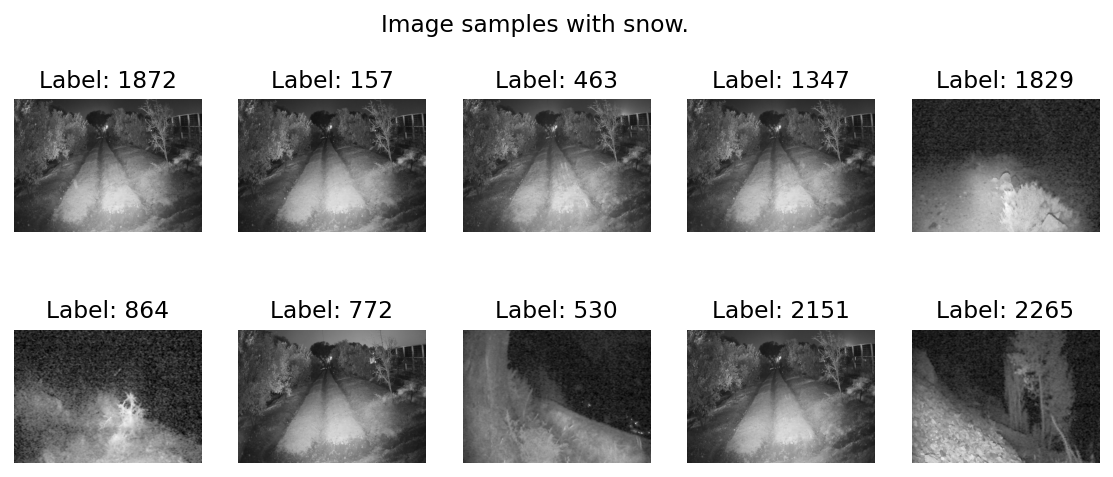

In [ ]:
# Visualization 
PLT_WIDTH = 5
PLT_HEIGHT = 2

plt.figure(figsize=(PLT_WIDTH*2, PLT_HEIGHT*2), dpi=140)
plt.suptitle("Image samples with snow. ")

count = 0
for image, label in snow_dataloader: 
    image = torch.squeeze(image).permute(1, 2, 0) 

    plt.subplot(PLT_HEIGHT, PLT_WIDTH, count + 1)
    plt.title(f"Label: {label.item()}")
    plt.axis(False)
    plt.imshow(image)
    
    count += 1
    if count == 10:
        break

plt.show()

# Model 1: Stacked Images Input 

Number of params: 135169

Accu on test data: 0.963534

### Loading the data

In [ ]:
# Declare custom dataset 
class LoadSnoweDatasetStacked(Dataset):
    ''' Custom dataset that loads 2 images and stack them on top of each other. '''
    def __init__(self, snow=True, transform=None, target_transform=None):
        self.img_labels = torch.tensor(1.0) if snow else torch.tensor(0.0)
        self.img_dir = SNOW_FOLDER if snow else NOTSNOW_FOLDER
        self.image_idx = os.listdir(self.img_dir)
        self.n_images = len(self.image_idx)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        # Get the folder id
        folder_id = self.image_idx[idx]
        # Retrive image 1 and image 2 and merge themm
        img_path1 = os.path.join(self.img_dir, folder_id, '0.png') # Get the folder path
        img_path2 = os.path.join(self.img_dir, folder_id, '1.png') # Get the folder path
        image1 = Image.open(img_path1)
        image2 = Image.open(img_path2)
        # Assign labels
        label = self.img_labels # Label will remain the same for both images
        # Apply transforms on images
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        # Stack two images on top 
        stacked_images = torch.cat([image1, image2])
        return stacked_images, label


### Preparing the data

In [ ]:
# Transforms  
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(), # Turn the image in gray scale
    torchvision.transforms.ToTensor(), # Convert the image into tesor
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
# Load the dataset for Stacked Images input Model
dataset_snow = LoadSnoweDatasetStacked(transform=transforms) # Snow dataset
dataset_notsnow = LoadSnoweDatasetStacked(snow=False, transform=transforms) # Not snow dataset

dataset = ConcatDataset([dataset_snow, dataset_notsnow]) # Combine the snow and not snow datasets
# Split the data sets into training and testing data 80-20 split
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])


# Create dataset loader for both training and testing datasets. 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)


### Model Creation

In [ ]:
# Create model class

class StackedImagesModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layers # 2, 456, 640
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 16, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 48, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(48, 64, 5, stride=2),
            nn.ReLU(),
        )
        self.linear1 = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(192, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.linear1(x)
        return x



### Model initialization and declaring hyperparameters

In [ ]:
torch.cuda.empty_cache()
model = StackedImagesModel().to(device)

In [ ]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 135169


In [ ]:
EPOCHS = 10
LEARNING_RATE = 1e-4
BATCH_SIZE = 32

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training the model

In [ ]:
loss_list = []
for epoch in range(EPOCHS):
    for idx, (img, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        img = img.to(device, non_blocking=True) # Send batch images to compute device
        y_train = model(img) # Model Output
        label = label.to(device, non_blocking=True).view(-1, 1)
        loss = criterion(y_train, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    loss_list.append(loss.item())


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:1, Loss:0.3051


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:2, Loss:0.8198


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:3, Loss:0.3049


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:4, Loss:0.2754


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:5, Loss:0.0202


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:6, Loss:0.0235


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:7, Loss:0.0877


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:8, Loss:0.4153


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:9, Loss:0.0400


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:10, Loss:0.0584


### Evaluating the model on test data

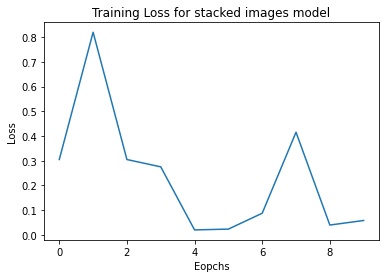

In [ ]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("Training Loss for stacked images model")
plt.plot(loss_list)

In [ ]:
outputs = []
for idx, (image, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
    with torch.no_grad():
        image = image.to(device)
        y_pred = model(image)
        y_pred = y_pred.cpu()

        outputs.append((y_pred, label.view(-1, 1))) 

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
y_pred = []
y_test = []
for (x, y) in outputs:
    y_pred += x
    y_test += y

y_pred = torch.Tensor(y_pred)
y_test = torch.Tensor(y_test)


In [ ]:
# Calculate Accuracy 
corr_count = torch.sum(y_pred.round() == y_test)
test_acc = corr_count/y_pred.shape[0]

print(f"Test Accuracy: {test_acc:.6f}")

Test Accuracy: 0.963534


# Model 2: Late merge with hard parameter sharing

Number of params: 160501

Accu on test data: 0.976157

### Declare and load dataset

In [ ]:
# Declare custom dataset 
class LoadSnoweDatasetPairs(Dataset):
    ''' Custom dataset that loads 2 images and return them as a tuple as (img1, img2, label). '''
    def __init__(self, snow=True, transform=None):
        self.img_labels = torch.tensor(1.0) if snow else torch.tensor(0.0)
        self.img_dir = SNOW_FOLDER if snow else NOTSNOW_FOLDER
        self.image_idx = os.listdir(self.img_dir)
        self.n_images = len(self.image_idx)
        self.transform = transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        # Get the folder id
        folder_id = self.image_idx[idx]
        # Retrive image 1 and image 2 and merge themm
        img_path1 = os.path.join(self.img_dir, folder_id, '0.png') # Get the folder path
        img_path2 = os.path.join(self.img_dir, folder_id, '1.png') # Get the folder path
        image1 = Image.open(img_path1)
        image2 = Image.open(img_path2)
        # Assign labels
        label = self.img_labels # Label will remain the same for both images
        # Apply transforms on images
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        # Stack two images on top 
        return image1, image2, label


In [ ]:
# Transforms  
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(), # Turn the image in gray scale
    torchvision.transforms.ToTensor(), # Convert the image into tesor
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# Load the dataset for Stacked Images input Model
dataset_snow = LoadSnoweDatasetPairs(transform=transforms) # Snow dataset
dataset_notsnow = LoadSnoweDatasetPairs(snow=False, transform=transforms) # Not snow dataset

dataset = ConcatDataset([dataset_snow, dataset_notsnow]) # Combine the snow and not snow datasets
# Split the data sets into training and testing data 80-20 split
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])


# Create dataset loader for both training and testing datasets. 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Create and instantiate the model

In [ ]:
class LateMergeWithHardPrams(nn.Module):
    ''' Workflow of model:
    Two seperate sequential convolution layers for both images
    Merge them togehter after convolution and send them to fully connected layers
    Classify based on merged input 
    '''
    def __init__(self):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 2, 3,),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 2, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        
        self.linear = nn.Sequential(
            nn.Linear(2356, 64),
            nn.ReLU(), 
            nn.Linear(64, 32),
            nn.ReLU(), 
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        # Pass through seperate layers
        conv1 = self.seq1(img1)
        conv2 = self.seq2(img2)
        # Merge the outputs
        x = torch.cat((conv1, conv2), dim=1)
        # Passthrough linear layers
        x = self.linear(x)

        return x




In [ ]:
torch.cuda.empty_cache()
model = LateMergeWithHardPrams().to(device)

In [ ]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 160501


In [ ]:
# Variables
EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
loss_list = []
for epoch in range(EPOCHS):
    for idx, (img1, img2, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # Send batch images to compute device
        img1 = img1.to(device, non_blocking=True) 
        img2 = img2.to(device, non_blocking=True) 
        y_train = model(img1, img2) # Recon = reconstructed image
        label = label.to(device, non_blocking=True).view(-1, 1)
        loss = criterion(y_train, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    loss_list.append(loss.item())

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:1, Loss:0.3959


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:2, Loss:0.2846


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:3, Loss:0.0548


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:4, Loss:0.0777


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:5, Loss:0.0459


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:6, Loss:0.0157


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:7, Loss:0.0781


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:8, Loss:0.0439


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:9, Loss:0.0232


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:10, Loss:0.0063


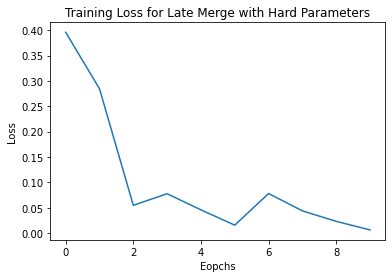

In [ ]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("Training Loss for Late Merge with Hard Parameters")
plt.plot(loss_list)

In [ ]:
outputs = []
for idx, (image1, image2, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
    with torch.no_grad():
        image1 = image1.to(device)
        image2 = image2.to(device)
        y_pred = model(image1, image2)
        y_pred = y_pred.cpu()

        outputs.append((y_pred, label.view(-1, 1))) 

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
y_pred = []
y_test = []
for (x, y) in outputs:
    y_pred += x
    y_test += y

y_pred = torch.Tensor(y_pred)
y_test = torch.Tensor(y_test)

In [ ]:
# Calculate Accuracy 
corr_count = torch.sum(y_pred.round() == y_test)
test_acc = corr_count/y_pred.shape[0]

print(f"Test Accuracy: {test_acc:.6f}")

Test Accuracy: 0.976157


# Model 3: Late merge with soft params

Number of params: 194073

Accu on test data: 0.970547


### Create and load the dataset

In [ ]:
# Declare custom dataset 
class LoadSnoweDatasetPairs(Dataset):
    ''' Custom dataset that loads 2 images and return them as a tuple as (img1, img2, label). '''
    def __init__(self, snow=True, transform=None):
        self.img_labels = torch.tensor(1.0) if snow else torch.tensor(0.0)
        self.img_dir = SNOW_FOLDER if snow else NOTSNOW_FOLDER
        self.image_idx = os.listdir(self.img_dir)
        self.n_images = len(self.image_idx)
        self.transform = transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        # Get the folder id
        folder_id = self.image_idx[idx]
        # Retrive image 1 and image 2 and merge themm
        img_path1 = os.path.join(self.img_dir, folder_id, '0.png') # Get the folder path
        img_path2 = os.path.join(self.img_dir, folder_id, '1.png') # Get the folder path
        image1 = Image.open(img_path1)
        image2 = Image.open(img_path2)
        # Assign labels
        label = self.img_labels # Label will remain the same for both images
        # Apply transforms on images
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        # Stack two images on top 
        return image1, image2, label


In [ ]:
# Transforms  
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(), # Turn the image in gray scale
    torchvision.transforms.ToTensor(), # Convert the image into tesor
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# Load the dataset for Stacked Images input Model
dataset_snow = LoadSnoweDatasetPairs(transform=transforms) # Snow dataset
dataset_notsnow = LoadSnoweDatasetPairs(snow=False, transform=transforms) # Not snow dataset

dataset = ConcatDataset([dataset_snow, dataset_notsnow]) # Combine the snow and not snow datasets
# Split the data sets into training and testing data 80-20 split
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])


# Create dataset loader for both training and testing datasets. 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Declare the model

In [ ]:
class LateMergeWithSoftParams(nn.Module):
    ''' Workflow of model:
    Same sequential convolution layer for both images
    Merge them togehter after convolution and send them to fully connected layers
    Classify based on merged input 
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 48, 5, stride=2), 
            nn.ReLU(), 
            nn.MaxPool2d(2), 
            nn.Conv2d(48, 32, 5, stride=2), 
            nn.ReLU(), 
            nn.MaxPool2d(2), 
            nn.Conv2d(32, 16, 5), 
            nn.ReLU(), 
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 3), 
            nn.ReLU(), 
            nn.Flatten(),
        )

        self.linear1 = nn.Sequential(
            nn.Linear(2160, 64), 
            nn.ReLU(), 
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        x1 = self.conv1(img1)
        x2 = self.conv1(img2)
        x = torch.cat((x1, x2), dim=1)
        x = self.linear1(x)

        return x


In [ ]:
torch.cuda.empty_cache()
model = LateMergeWithSoftParams().to(device)

In [ ]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 194073


In [ ]:
# Variables
EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Train the model

In [ ]:
loss_list = []
for epoch in range(EPOCHS):
    for idx, (img1, img2, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # Send batch images to compute device
        img1 = img1.to(device, non_blocking=True) 
        img2 = img2.to(device, non_blocking=True) 
        y_train = model(img1, img2) # Recon = reconstructed image
        label = label.to(device, non_blocking=True).view(-1, 1)
        loss = criterion(y_train, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    loss_list.append(loss.item())

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:1, Loss:0.3953


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:2, Loss:0.9174


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:3, Loss:0.2262


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:4, Loss:0.0882


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:5, Loss:0.0184


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:6, Loss:0.0313


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:7, Loss:0.0042


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:8, Loss:0.0249


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:9, Loss:0.0514


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:10, Loss:0.0106


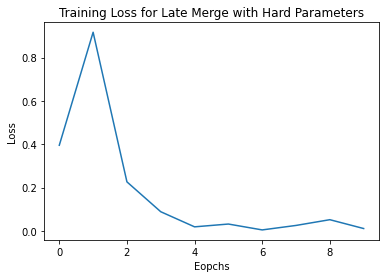

In [ ]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("Training Loss for Late Merge with Soft Parameters")
plt.plot(loss_list)

### Test the model

In [ ]:
outputs = []
for idx, (image1, image2, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
    with torch.no_grad():
        image1 = image1.to(device)
        image2 = image2.to(device)
        y_pred = model(image1, image2)
        y_pred = y_pred.cpu()

        outputs.append((y_pred, label.view(-1, 1)))

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
y_pred = []
y_test = []
for (x, y) in outputs:
    y_pred += x
    y_test += y

y_pred = torch.Tensor(y_pred)
y_test = torch.Tensor(y_test)

In [ ]:
# Calculate Accuracy 
corr_count = torch.sum(y_pred.round() == y_test)
test_acc = corr_count/y_pred.shape[0]

print(f"Test Accuracy: {test_acc:.6f}")

Test Accuracy: 0.970547


# Model 4: Early merge with hard params

Number of params: 142777

Accu on test data: 0.960729

### Create and load Dataset

In [ ]:
# Declare custom dataset 
class LoadSnoweDatasetPairs(Dataset):
    ''' Custom dataset that loads 2 images and return them as a tuple as (img1, img2, label). '''
    def __init__(self, snow=True, transform=None):
        self.img_labels = torch.tensor(1.0) if snow else torch.tensor(0.0)
        self.img_dir = SNOW_FOLDER if snow else NOTSNOW_FOLDER
        self.image_idx = os.listdir(self.img_dir)
        self.n_images = len(self.image_idx)
        self.transform = transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        # Get the folder id
        folder_id = self.image_idx[idx]
        # Retrive image 1 and image 2 and merge themm
        img_path1 = os.path.join(self.img_dir, folder_id, '0.png') # Get the folder path
        img_path2 = os.path.join(self.img_dir, folder_id, '1.png') # Get the folder path
        image1 = Image.open(img_path1)
        image2 = Image.open(img_path2)
        # Assign labels
        label = self.img_labels # Label will remain the same for both images
        # Apply transforms on images
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        # Stack two images on top 
        return image1, image2, label


In [ ]:
# Transforms  
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(), # Turn the image in gray scale
    torchvision.transforms.ToTensor(), # Convert the image into tesor
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# Load the dataset for Stacked Images input Model
dataset_snow = LoadSnoweDatasetPairs(transform=transforms) # Snow dataset
dataset_notsnow = LoadSnoweDatasetPairs(snow=False, transform=transforms) # Not snow dataset

dataset = ConcatDataset([dataset_snow, dataset_notsnow]) # Combine the snow and not snow datasets
# Split the data sets into training and testing data 80-20 split
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])


# Create dataset loader for both training and testing datasets. 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)

### Create and Inistantiate model

In [ ]:
class EarlyMergeWithHardParams(nn.Module):
    '''
    Model workflow: 
    Takes 2 images as input and perform single layer convolution 
    Merge the result after one layer
    Perform more convolution on the merged images
    After convolution use fully connected layers to classify. 
    '''
    def __init__(self):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(64, 32, 5, stride=2),
            nn.ReLU(), 
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 3), 
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(1280, 64),
            nn.ReLU(), 
            nn.Linear(64, 32),
            nn.ReLU(), 
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        conv1 = self.seq1(img1)
        conv2 = self.seq2(img2)
        x = torch.cat((conv1, conv2), dim=1) # 1 dim coz batch
        x = self.conv(x)
        x = self.flatten(x)
        x = self.linear(x)

        return x


In [ ]:
torch.cuda.empty_cache()
model = EarlyMergeWithHardParams().to(device)

In [ ]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")


Number of trainable parameters are: 142777


In [ ]:
# Variables
EPOCHS = 10
LEARNING_RATE = 3e-4
BATCH_SIZE = 32

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Model Training

In [ ]:

loss_list = []
for epoch in range(EPOCHS):
    for idx, (img1, img2, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # Send batch images to compute device
        img1 = img1.to(device, non_blocking=True) 
        img2 = img2.to(device, non_blocking=True) 
        y_train = model(img1, img2) # Recon = reconstructed image
        label = label.to(device, non_blocking=True).view(-1, 1)
        loss = criterion(y_train, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    loss_list.append(loss.item())

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:1, Loss:0.5435


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:2, Loss:0.2480


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:3, Loss:0.4344


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:4, Loss:0.0639


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:5, Loss:0.5504


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:6, Loss:0.2390


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:7, Loss:0.2413


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:8, Loss:0.0119


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:9, Loss:0.1510


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:10, Loss:0.0727


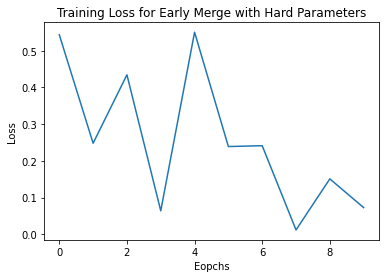

In [ ]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("Training Loss for Early Merge with Hard Parameters")
plt.plot(loss_list)

In [ ]:
outputs = []
for idx, (image1, image2, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
    with torch.no_grad():
        image1 = image1.to(device)
        image2 = image2.to(device)
        y_pred = model(image1, image2)
        y_pred = y_pred.cpu()

        outputs.append((y_pred, label.view(-1, 1))) 

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
y_pred = []
y_test = []
for (x, y) in outputs:
    y_pred += x
    y_test += y

y_pred = torch.Tensor(y_pred)
y_test = torch.Tensor(y_test)

In [ ]:
# Calculate Accuracy 
corr_count = torch.sum(y_pred.round() == y_test)
test_acc = corr_count/y_pred.shape[0]

print(f"Test Accuracy: {test_acc:.6f}")

Test Accuracy: 0.960729


# Model 5: Early merge with soft params

Number of params: 55873

Accu on test data: 0.963534

### Create and load Dataset

In [ ]:
# Declare custom dataset 
class LoadSnoweDatasetPairs(Dataset):
    ''' Custom dataset that loads 2 images and return them as a tuple as (img1, img2, label). '''
    def __init__(self, snow=True, transform=None):
        self.img_labels = torch.tensor(1.0) if snow else torch.tensor(0.0)
        self.img_dir = SNOW_FOLDER if snow else NOTSNOW_FOLDER
        self.image_idx = os.listdir(self.img_dir)
        self.n_images = len(self.image_idx)
        self.transform = transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        # Get the folder id
        folder_id = self.image_idx[idx]
        # Retrive image 1 and image 2 and merge themm
        img_path1 = os.path.join(self.img_dir, folder_id, '0.png') # Get the folder path
        img_path2 = os.path.join(self.img_dir, folder_id, '1.png') # Get the folder path
        image1 = Image.open(img_path1)
        image2 = Image.open(img_path2)
        # Assign labels
        label = self.img_labels # Label will remain the same for both images
        # Apply transforms on images
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        # Stack two images on top 
        return image1, image2, label


In [ ]:
# Transforms  
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(), # Turn the image in gray scale
    torchvision.transforms.ToTensor(), # Convert the image into tesor
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# Load the dataset for Stacked Images input Model
dataset_snow = LoadSnoweDatasetPairs(transform=transforms) # Snow dataset
dataset_notsnow = LoadSnoweDatasetPairs(snow=False, transform=transforms) # Not snow dataset

dataset = ConcatDataset([dataset_snow, dataset_notsnow]) # Combine the snow and not snow datasets
# Split the data sets into training and testing data 80-20 split
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])


# Create dataset loader for both training and testing datasets. 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)

### Create and Inistantiate model

In [ ]:
class EarlyMergeWithSoftParams(nn.Module):
    '''
    Model workflow: 
    Takes 2 images as input and perform single layer convolution 
    Merge the result after one layer
    Perform more convolution on the merged images
    After convolution use fully connected layers to classify. 
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 48, 3, stride=2),
            nn.ReLU(), 
            nn.MaxPool2d(2),
            nn.Conv2d(48, 32, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, 3), 
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(288, 16),
            nn.ReLU(), 
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        conv1 = self.conv1(img1)
        conv2 = self.conv1(img2)
        x = torch.cat((conv1, conv2), dim=1) # 1 dim coz batch
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.linear(x)

        return x


In [ ]:
torch.cuda.empty_cache()
model = EarlyMergeWithSoftParams().to(device)

In [ ]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")


Number of trainable parameters are: 55873


In [ ]:
# Variables
EPOCHS = 10
LEARNING_RATE = 3e-4
BATCH_SIZE = 32

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Model Training

In [ ]:
loss_list = []
for epoch in range(EPOCHS):
    for idx, (img1, img2, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # Send batch images to compute device
        img1 = img1.to(device, non_blocking=True) 
        img2 = img2.to(device, non_blocking=True) 
        y_train = model(img1, img2) # Recon = reconstructed image
        label = label.to(device, non_blocking=True).view(-1, 1)
        loss = criterion(y_train, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    loss_list.append(loss.item())

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:1, Loss:0.1715


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:2, Loss:0.1792


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:3, Loss:0.0970


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:4, Loss:0.2536


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:5, Loss:0.8142


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:6, Loss:0.2655


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:7, Loss:0.7303


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:8, Loss:0.1641


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:9, Loss:0.0263


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:10, Loss:0.0902


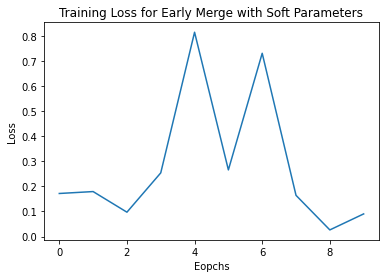

In [ ]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("Training Loss for Early Merge with Soft Parameters")
plt.plot(loss_list)

In [ ]:
outputs = []
for idx, (image1, image2, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
    with torch.no_grad():
        image1 = image1.to(device)
        image2 = image2.to(device)
        y_pred = model(image1, image2)
        y_pred = y_pred.cpu()

        outputs.append((y_pred, label.view(-1, 1))) 

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
y_pred = []
y_test = []
for (x, y) in outputs:
    y_pred += x
    y_test += y

y_pred = torch.Tensor(y_pred)
y_test = torch.Tensor(y_test)

In [ ]:
# Calculate Accuracy 
corr_count = torch.sum(y_pred.round() == y_test)
test_acc = corr_count/y_pred.shape[0]

print(f"Test Accuracy: {test_acc:.6f}")

Test Accuracy: 0.963534


# Model 6: Stacked image input with Weight Decay (L2 Regularization)

Weight Decay Rate: 0.001

### Loading the data

In [ ]:
# Declare custom dataset 
class LoadSnoweDatasetStacked(Dataset):
    ''' Custom dataset that loads 2 images and stack them on top of each other. '''
    def __init__(self, snow=True, transform=None, target_transform=None):
        self.img_labels = torch.tensor(1.) if snow else torch.tensor(0.)
        self.img_dir = SNOW_FOLDER if snow else NOTSNOW_FOLDER
        self.image_idx = os.listdir(self.img_dir)
        self.n_images = len(self.image_idx)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        # Get the folder id
        folder_id = self.image_idx[idx]
        # Retrive image 1 and image 2 and merge themm
        img_path1 = os.path.join(self.img_dir, folder_id, '0.png') # Get the folder path
        img_path2 = os.path.join(self.img_dir, folder_id, '1.png') # Get the folder path
        image1 = Image.open(img_path1)
        image2 = Image.open(img_path2)
        # Assign labels
        label = self.img_labels # Label will remain the same for both images
        # Apply transforms on images
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        if self.target_transform:
            label = self.target_transform(label)
        # Stack two images on top 
        stacked_images = torch.cat([image1, image2])
        return stacked_images, label


### Preparing the data

In [ ]:
# Transforms  
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(), # Turn the image in gray scale
    torchvision.transforms.ToTensor(), # Convert the image into tesor
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
# Load the dataset for Stacked Images input Model
dataset_snow = LoadSnoweDatasetStacked(transform=transforms) # Snow dataset
dataset_notsnow = LoadSnoweDatasetStacked(snow=False, transform=transforms) # Not snow dataset

dataset = ConcatDataset([dataset_snow, dataset_notsnow]) # Combine the snow and not snow datasets
# Split the data sets into training and testing data 80-20 split
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])


# Create dataset loader for both training and testing datasets. 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)


### Model Creation

In [ ]:
# Create model class

class StackedImagesModelForRegularization(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layers # 2, 456, 640
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 16, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 48, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(48, 64, 5, stride=2),
            nn.ReLU(),
        )
        self.linear1 = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(192, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.linear1(x)
        return x



### Model initialization and declaring hyperparameters

In [ ]:
torch.cuda.empty_cache()
model = StackedImagesModelForRegularization().to(device)

In [ ]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 135169


In [ ]:
LABEL_SMOOTHING = 0.001
EPOCHS = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 32

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

### Training the model

In [24]:
loss_list = []
for epoch in range(EPOCHS):
    for idx, (img, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        img = img.to(device, non_blocking=True) # Send batch images to compute device
        y_train = model(img) # Model Output
        label = label.to(device, non_blocking=True).view(-1, 1)
        loss = criterion(y_train, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    loss_list.append(loss.item())


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:1, Loss:0.0561


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:2, Loss:0.0174


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:3, Loss:0.0277


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:4, Loss:0.0410


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:5, Loss:0.0693


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:6, Loss:0.0604


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:7, Loss:0.2120


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:8, Loss:0.0064


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:9, Loss:0.0106


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:10, Loss:0.4433


### Evaluating the model on test data

In [25]:
outputs = []
for idx, (image, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
    with torch.no_grad():
        image = image.to(device)
        y_pred = model(image)
        y_pred = y_pred.cpu()

        outputs.append((y_pred, label.view(-1, 1))) 

  0%|          | 0/23 [00:00<?, ?it/s]

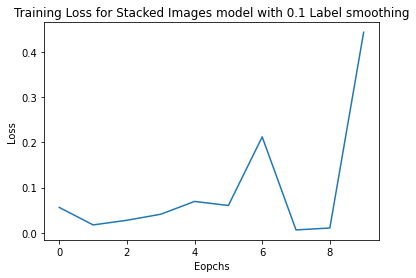

In [26]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("Training Loss for Stacked Images model with 0.1 Label smoothing")
plt.plot(loss_list)

In [27]:
y_pred = []
y_test = []
for (x, y) in outputs:
    y_pred += x
    y_test += y

y_pred = torch.Tensor(y_pred)
y_test = torch.Tensor(y_test)


In [28]:
# Calculate Accuracy 
corr_count = torch.sum(y_pred.round() == y_test)
test_acc = corr_count/y_pred.shape[0]

print(f"Test Accuracy: {test_acc:.6f}")

Test Accuracy: 0.966339


# Model 7: Data Augmentation 

In [ ]:
# Declare custom dataset 
class LoadSnoweDatasetStacked(Dataset):
    ''' Custom dataset that loads 2 images and stack them on top of each other. '''
    def __init__(self, snow=True, transform=None, target_transform=None):
        self.img_labels = torch.tensor(1.) if snow else torch.tensor(0.)
        self.img_dir = SNOW_FOLDER if snow else NOTSNOW_FOLDER
        self.image_idx = os.listdir(self.img_dir)
        self.n_images = len(self.image_idx)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        # Get the folder id
        folder_id = self.image_idx[idx]
        # Retrive image 1 and image 2 and merge themm
        img_path1 = os.path.join(self.img_dir, folder_id, '0.png') # Get the folder path
        img_path2 = os.path.join(self.img_dir, folder_id, '1.png') # Get the folder path
        image1 = Image.open(img_path1)
        image2 = Image.open(img_path2)
        # Assign labels
        label = self.img_labels # Label will remain the same for both images
        # Apply transforms on images
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        if self.target_transform:
            label = self.target_transform(label)
        # Stack two images on top 
        stacked_images = torch.cat([image1, image2])
        return stacked_images, label


## Augment the data with transforms

In [ ]:
# Transforms  
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(), # Turn the image in gray scale
    torchvision.transforms.ToTensor(), # Convert the image into tesor
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.3), # Turn the image in gray scale
    torchvision.transforms.RandomVerticalFlip(p=0.3), # Turn the image in gray scale
    torchvision.transforms.RandomRotation(80), # Turn the image in gray scale
])


In [ ]:
# Load the dataset for Stacked Images input Model
dataset_snow = LoadSnoweDatasetStacked(transform=transforms) # Snow dataset
dataset_notsnow = LoadSnoweDatasetStacked(snow=False, transform=transforms) # Not snow dataset

dataset = ConcatDataset([dataset_snow, dataset_notsnow]) # Combine the snow and not snow datasets
# Split the data sets into training and testing data 80-20 split
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataset.dataset.transform = train_transforms

# Create dataset loader for both training and testing datasets. 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)


In [ ]:
# Create model class

class StackedImagesModelwithDataAugmentation(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layers # 2, 456, 640
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 16, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 48, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(48, 64, 5, stride=2),
            nn.ReLU(),
        )
        self.linear1 = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(192, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.linear1(x)
        return x



In [ ]:
torch.cuda.empty_cache()
model = StackedImagesModelwithDataAugmentation().to(device)

In [ ]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 135169


In [ ]:
EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training the model

In [ ]:
loss_list = []
for epoch in range(EPOCHS):
    for idx, (img, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        img = img.to(device, non_blocking=True) # Send batch images to compute device
        y_train = model(img) # Model Output
        label = label.to(device, non_blocking=True).view(-1, 1)
        loss = criterion(y_train, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    loss_list.append(loss.item())


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:1, Loss:0.3083


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:2, Loss:0.0438


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:3, Loss:0.0897


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:4, Loss:0.0606


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:5, Loss:2.4099


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:6, Loss:0.6654


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:7, Loss:0.0459


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:8, Loss:0.0227


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:9, Loss:0.3982


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:10, Loss:0.0088


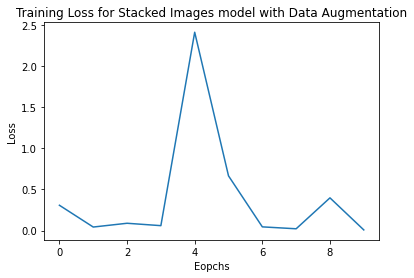

In [ ]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("Training Loss for Stacked Images model with Data Augmentation")
plt.plot(loss_list)

## Running in test data

In [ ]:
outputs = []
for idx, (image, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
    with torch.no_grad():
        image = image.to(device)
        y_pred = model(image)
        y_pred = y_pred.cpu()

        outputs.append((y_pred, label.view(-1, 1))) 

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
y_pred = []
y_test = []
for (x, y) in outputs:
    y_pred += x
    y_test += y

y_pred = torch.Tensor(y_pred)
y_test = torch.Tensor(y_test)


In [ ]:
# Calculate Accuracy 
corr_count = torch.sum(y_pred.round() == y_test)
test_acc = corr_count/y_pred.shape[0]

print(f"Test Accuracy: {test_acc:.6f}")

Test Accuracy: 0.977560


# Model 8: Stacked Model with lower spatial dimension and large no of filters.

Number of params: 135169

Accu on test data: 0.963534

### Loading the data

In [ ]:
# Declare custom dataset 
class LoadSnoweDatasetStacked(Dataset):
    ''' Custom dataset that loads 2 images and stack them on top of each other. '''
    def __init__(self, snow=True, transform=None, target_transform=None):
        self.img_labels = torch.tensor(1.0) if snow else torch.tensor(0.0)
        self.img_dir = SNOW_FOLDER if snow else NOTSNOW_FOLDER
        self.image_idx = os.listdir(self.img_dir)
        self.n_images = len(self.image_idx)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        # Get the folder id
        folder_id = self.image_idx[idx]
        # Retrive image 1 and image 2 and merge themm
        img_path1 = os.path.join(self.img_dir, folder_id, '0.png') # Get the folder path
        img_path2 = os.path.join(self.img_dir, folder_id, '1.png') # Get the folder path
        image1 = Image.open(img_path1)
        image2 = Image.open(img_path2)
        # Assign labels
        label = self.img_labels # Label will remain the same for both images
        # Apply transforms on images
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        # Stack two images on top 
        stacked_images = torch.cat([image1, image2])
        return stacked_images, label


### Preparing the data

In [ ]:
# Transforms  
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(), # Turn the image in gray scale
    torchvision.transforms.ToTensor(), # Convert the image into tesor
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
# Load the dataset for Stacked Images input Model
dataset_snow = LoadSnoweDatasetStacked(transform=transforms) # Snow dataset
dataset_notsnow = LoadSnoweDatasetStacked(snow=False, transform=transforms) # Not snow dataset

dataset = ConcatDataset([dataset_snow, dataset_notsnow]) # Combine the snow and not snow datasets
# Split the data sets into training and testing data 80-20 split
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])


# Create dataset loader for both training and testing datasets. 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)


### Model Creation

In [ ]:
# Create model class

class StackedImagesModelwithEMA(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layers # 2, 456, 640
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 162, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(162, 200, 5),
            nn.ReLU(),
        )
        self.linear1 = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(384, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.linear1(x)
        return x



### Model initialization and declaring hyperparameters

In [ ]:
torch.cuda.empty_cache()
model = StackedImagesModelwithEMA().to(device)

In [ ]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 282193


In [ ]:
EPOCHS = 10
LEARNING_RATE = 1e-4
BATCH_SIZE = 32

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training the model

In [ ]:

loss_list = []
for epoch in range(EPOCHS):
    for idx, (img, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        img = img.to(device, non_blocking=True) # Send batch images to compute device
        y_train = model(img) # Model Output
        label = label.to(device, non_blocking=True).view(-1, 1)
        loss = criterion(y_train, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    loss_list.append(loss.item())


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:1, Loss:0.5650


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:2, Loss:0.3368


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:3, Loss:0.4588


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:4, Loss:0.1598


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:5, Loss:0.2844


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:6, Loss:0.0634


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:7, Loss:0.1572


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:8, Loss:0.1200


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:9, Loss:0.9260


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:10, Loss:0.0607


### Evaluating the model on test data

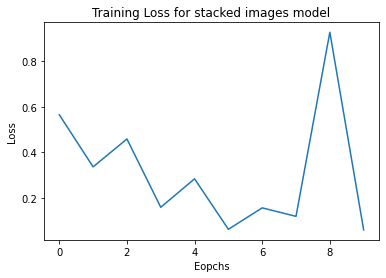

In [ ]:
plt.title("Loss")
plt.xlabel("Eopchs")
plt.ylabel("Loss")
plt.title("Training Loss for stacked images model with large number of filters")
plt.plot(loss_list)

In [ ]:
outputs = []
for idx, (image, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
    with torch.no_grad():
        image = image.to(device)
        y_pred = model(image)
        y_pred = y_pred.cpu()

        outputs.append((y_pred, label.view(-1, 1))) 

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
y_pred = []
y_test = []
for (x, y) in outputs:
    y_pred += x
    y_test += y

y_pred = torch.Tensor(y_pred)
y_test = torch.Tensor(y_test)


In [ ]:
# Calculate Accuracy 
corr_count = torch.sum(y_pred.round() == y_test)
test_acc = corr_count/y_pred.shape[0]

print(f"Test Accuracy: {test_acc:.6f}")

Test Accuracy: 0.943899
